# Generating Dataset

In [1]:
import cv2
'''
cap = cv2.VideoCapture(0)

count1 = 0
count2 = 0
count3 = 0
count4 = 0
while(True):
    ret, frame = cap.read()
    cv2.imshow("Live Video", frame)


    if(cv2.waitKey(1) & 0xFF == ord('a')):
        count1 += 1
        cv2.imwrite(f"dataset/gesture_1/gesture_1_{count1}.jpg", frame)

    if(cv2.waitKey(1) & 0xFF == ord('b')):
        count2 += 1
        cv2.imwrite(f"dataset/gesture_2/gesture_2_{count2}.jpg", frame)

    if(cv2.waitKey(1) & 0xFF == ord('c')):
        count3 += 1
        cv2.imwrite(f"dataset/gesture_3/gesture_3_{count3}.jpg", frame)

    if(cv2.waitKey(1) & 0xFF == ord('d')):
        count4 += 1
        cv2.imwrite(f"dataset/gesture_4/gesture_4_{count4}.jpg", frame)

    if(cv2.waitKey(1) & 0xFF == ord('q')):
        cap.release()
        cv2.destroyAllWindows()
        break'''

'\ncap = cv2.VideoCapture(0)\n\ncount1 = 0\ncount2 = 0\ncount3 = 0\ncount4 = 0\nwhile(True):\n    ret, frame = cap.read()\n    cv2.imshow("Live Video", frame)\n\n\n    if(cv2.waitKey(1) & 0xFF == ord(\'a\')):\n        count1 += 1\n        cv2.imwrite(f"dataset/gesture_1/gesture_1_{count1}.jpg", frame)\n\n    if(cv2.waitKey(1) & 0xFF == ord(\'b\')):\n        count2 += 1\n        cv2.imwrite(f"dataset/gesture_2/gesture_2_{count2}.jpg", frame)\n\n    if(cv2.waitKey(1) & 0xFF == ord(\'c\')):\n        count3 += 1\n        cv2.imwrite(f"dataset/gesture_3/gesture_3_{count3}.jpg", frame)\n\n    if(cv2.waitKey(1) & 0xFF == ord(\'d\')):\n        count4 += 1\n        cv2.imwrite(f"dataset/gesture_4/gesture_4_{count4}.jpg", frame)\n\n    if(cv2.waitKey(1) & 0xFF == ord(\'q\')):\n        cap.release()\n        cv2.destroyAllWindows()\n        break'

# Save Files in CSV

In [2]:
import os
import csv

# Base directory where the dataset is stored
base_dir = "dataset"

# Output CSV file
output_csv = "images.csv"

# Open the CSV file for writing
with open(output_csv, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    
    # Write the headers
    writer.writerow(["Path", "Label"])
    
    # Walk through the dataset directory
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        
        # Ensure it's a folder
        if os.path.isdir(folder_path):
            label = folder_name  # Use folder name as the label
            if folder_name == "gesture_1":
                label = "checazzo"
            if folder_name == "gesture_2":
                label = "peace"
            if folder_name == "gesture_3":
                label = "nice"
            if folder_name == "gesture_4":
                label = "nogesture"

            
            # Loop through each file in the folder
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                
                # Ensure it's an image file (check extension)
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    # Write the relative path and label to the CSV
                    writer.writerow([file_path, label])

print(f"Images and labels have been saved to {output_csv}")

Images and labels have been saved to images.csv


# Initialize functions

In [3]:
import os
import pandas as pd
import torchvision
import torch
from torchvision import transforms

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from PIL import Image



class CustomImageDataset(Dataset):
    def __init__(self, root_dir,csv_file, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = {cls: idx for idx, cls in enumerate(
            ['checazzo', 'peace', 'nice', 'nogesture'])}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path)
        image = image.convert("RGB")


        label = self.annotations.iloc[idx, 1]
        label = self.class_to_idx[label]

        if self.transform:
            image = self.transform(image)
        
        return image, label

In [4]:
import cv2
import numpy as np
import random


class CustomTransform:
    def __init__(self):
        self.counter_rotation = 0
        self.counter_flipping = 0
        self.counter_blurring = 0
        self.counter_sharpening = 0
        self.counter_noise = 0

    def random_rotation(self, image):
        """Rotate the image by a random angle (45, 90, or 135 degrees) without changing colors."""
        # Reshape image to (height, width, channels)
        image = np.transpose(image, (1, 2, 0))  # Convert (3, 64, 64) to (64, 64, 3)
        rows, cols = image.shape[:2]
        
        # Randomly choose an angle: 45, 90, 135 or 180 degrees
        angle = random.choice([90,180,270])

        # Compute the rotation matrix
        M = cv2.getRotationMatrix2D(((cols - 1) / 2.0, (rows - 1) / 2.0), angle, 1)
        
        # Perform the rotation
        dst = cv2.warpAffine(image, M, (cols, rows))
        
        # Reshape image back to (channels, height, width)
        dst = np.transpose(dst, (2, 0, 1))  # Convert (64, 64, 3) back to (3, 64, 64)
        
        self.counter_rotation += 1
        return dst



    def random_flipping(self, image):
        """Flip the image randomly."""
        flip_code = random.choice([-1, 0, 1])  # -1: both axes, 0: vertical, 1: horizontal
        flipped = cv2.flip(image, flip_code)
        self.counter_flipping += 1
        return flipped

    def random_blurring(self, image):
        """Apply random Gaussian blur."""
        kernel_size = random.choice([3, 5, 7])  # Use smaller kernel sizes (3,5 or 7)
        blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
        self.counter_blurring += 1
        return blurred

    def random_sharpening(self, image):
        """Apply a sharpening kernel to the image."""
        kernel = np.array([[-1,-1,-1], 
                           [-1, 9,-1],
                           [-1,-1,-1]])  # Standard sharpening kernel
        sharpened = cv2.filter2D(image, -1, kernel) # Apply the sharpening kernel
        self.counter_sharpening += 1
        return sharpened

    def add_random_noise(self, image):
        """Add random Gaussian noise to an image with controlled intensity."""
        # Transpose image to (height, width, channels) if it's in (channels, height, width)
        image = np.transpose(image, (1, 2, 0))  # (3, 64, 64) to (64, 64, 3)
        
        row, col, ch = image.shape[:3]
        mean = 0
        var = random.uniform(0.001, 0.005)  # Randomly vary the variance (increase from before)
        sigma = var ** 0.5  # Standard deviation is the square root of variance
        
        # Generate Gaussian noise with the updated variance and sigma
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        
        # Add the Gaussian noise to the image
        noisy = image + gauss

        # Clip the image to ensure pixel values are between 0 and 255
        #noisy = np.clip(noisy, 0, 255).astype(np.uint8)

        # Transpose back to (3, 64, 64)
        noisy_image = np.transpose(noisy, (2, 0, 1))  # (64, 64, 3) to (3, 64, 64)

        self.counter_noise += 1
        return noisy_image

    
    # Apply random augmentations
    def __call__(self, image):
        """Apply a random combination of augmentations."""
        augmentations = [
            self.random_rotation,
            self.random_flipping,
            self.random_blurring,
            self.random_sharpening,
            self.add_random_noise
        ]
        random.shuffle(augmentations)  # Shuffle the order of augmentations
    
        # Apply only the first transformation from the shuffled list
        image = augmentations[0](image)
    
        return image, self.counter_rotation, self.counter_flipping, self.counter_blurring, self.counter_sharpening, self.counter_noise  # Return the image and the augmentation counters


In [5]:
import os
import numpy as np
import torch
from PIL import Image
import random
import shutil

# Augment Dataset with Labels and Save Images
def augment_and_add_to_dataset(dataset, transform, num_augmentations=1, save_dir='augmented_dataset'):
    """
    Augment the dataset by applying transformations to each image
    and appending the augmented images with the same labels to the dataset.
    Saves the augmented images in class-specific directories.

    Args:
        dataset: The original dataset (CustomImageDataset or similar).
        transform: The transformation class with custom augmentation functions.
        num_augmentations: Number of augmented versions to create per image.
        save_dir: Root directory where augmented images will be saved.

    Returns:
        Augmented dataset (list of tuples with image tensor and label).
    """
    counter_rotation = 0
    counter_flipping = 0
    counter_blurring = 0
    counter_sharpening = 0
    counter_noise = 0



       # Clear the directory if it exists
    if os.path.exists(save_dir):
        shutil.rmtree(save_dir)  # Delete everything inside the folder
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Create the base directory for augmented dataset

    augmented_data = []

    for idx in range(len(dataset)):
        image, label = dataset[idx]
        
        # Convert tensor back to numpy for transformation
        original_image = image.squeeze(0).numpy()
        #print(original_image.shape)
        # Add the original image and label
        augmented_data.append((image, label))

        # Create class-specific directory if it doesn't exist
        class_dir = os.path.join(save_dir, f'class_{label}')
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        # Save the original image
        save_image(original_image, class_dir, num_augmentations, 'original')

        # Create augmented versions and save them
        for i in range(num_augmentations):
            augmented_image, counter_rotation,counter_flipping, counter_blurring, counter_sharpening, counter_noise = transform(original_image)
            augmented_image_tensor = torch.tensor(augmented_image)
            
            # Save augmented image
            save_image(augmented_image, class_dir,num_augmentations, f'aug_{i + 1}')
            #print(augmented_image.shape)
            augmented_data.append((augmented_image_tensor, label))
            

     # Apply only the first transformation from the shuffled list
    print("Counter rotation: ", counter_rotation)
    print("Counter flipping: ", counter_flipping)
    print("Counter blurring: ", counter_blurring)
    print("Counter sharpening: ", counter_sharpening)
    print("Counter noise: ", counter_noise)
    return augmented_data


def save_image(image, class_dir, num_augmentations, suffix):
    """
    Save the image to the specified directory with the given suffix.
    """
    
    # If the image has shape (channels, height, width), transpose to (height, width, channels)
    if image.ndim == 3 and image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))
    
    # Convert to uint8 if necessary
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8

    #print(f"Processed image shape: {image.shape}, dtype: {image.dtype}")

    # Convert the numpy array to a PIL image
    pil_image = Image.fromarray(image)

    # Create a unique filename for each image
    filename = f"{suffix}_{random.randint(0, 1000)}.jpg"  # Adding randomness to avoid overwriting

    # Save the image in the class directory
    pil_image.save(os.path.join(class_dir, filename))





In [6]:
seed = 42
generator = torch.Generator().manual_seed(seed)

current_dir = os.getcwd()
print(f"Current directory: {current_dir}")


classes = ('checazzo', 'peace', 'nice', 'nogesture')

# Set up transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)), # Resize the image to 32x32
    transforms.ToTensor(),  # Converts to tensor of shape [1, H, W]
    ])

# Instantiate custom transformation
custom_transform_100 = CustomTransform()
custom_transform_200 = CustomTransform()
custom_transform_300 = CustomTransform()

# Create dataset
original_dataset = CustomImageDataset(csv_file='images.csv', root_dir=os.getcwd(), transform=transform)
print(f"Original dataset size: {len(original_dataset)}")
# Split dataset into 80% train and 20% test
train_size_original = int(0.8 * len(original_dataset))
test_size_original = len(original_dataset) - train_size_original
train_set_original, test_set_original = random_split(original_dataset, [train_size_original, test_size_original],generator=generator)
# Create DataLoaders
train_loader_original = DataLoader(train_set_original, batch_size=32, shuffle=True)
test_loader_original = DataLoader(test_set_original, batch_size=32, shuffle=False)


# Augment the dataset by 100 images per class
num_augmentations_100 = 1  # Number of augmented versions per original image
dataset_100 = augment_and_add_to_dataset(original_dataset, custom_transform_100, num_augmentations_100, save_dir='augmented_dataset100')
print(f"Augmented dataset size: {len(dataset_100)}")
# Split dataset into 80% train and 20% test
train_size_100 = int(0.8 * len(dataset_100))
test_size_100 = len(dataset_100) - train_size_100
train_set_100, test_set_100 = random_split(dataset_100, [train_size_100, test_size_100],generator=generator)
# Create DataLoaders
train_loader_100 = DataLoader(train_set_100, batch_size=32, shuffle=True)
test_loader_100 = DataLoader(test_set_100, batch_size=32, shuffle=False)

# Augment the dataset by 200 images per class
num_augmentations_200 = 2  # Number of augmented versions per original image
dataset_200 = augment_and_add_to_dataset(original_dataset, custom_transform_200, num_augmentations_200, save_dir='augmented_dataset200')
print(f"Augmented dataset size: {len(dataset_200)}")
# Split dataset into 80% train and 20% test
train_size_200 = int(0.8 * len(dataset_200))
test_size_200 = len(dataset_200) - train_size_200
train_set_200, test_set_200 = random_split(dataset_200, [train_size_200, test_size_200],generator=generator)
# Create DataLoaders
train_loader_200 = DataLoader(train_set_200, batch_size=32, shuffle=True)
test_loader_200 = DataLoader(test_set_200, batch_size=32, shuffle=False)

# Augment the dataset by 300 images per class
num_augmentations_300 = 3  # Number of augmented versions per original image
dataset_300 = augment_and_add_to_dataset(original_dataset, custom_transform_300, num_augmentations_300, save_dir='augmented_dataset300')
print(f"Augmented dataset size: {len(dataset_300)}")
# Split dataset into 80% train and 20% test
train_size_300 = int(0.8 * len(dataset_300))
test_size_300 = len(dataset_300) - train_size_300
train_set_300, test_set_300 = random_split(dataset_300, [train_size_300, test_size_300],generator=generator)
# Create DataLoaders
train_loader_300 = DataLoader(train_set_300, batch_size=32, shuffle=True)
test_loader_300 = DataLoader(test_set_300, batch_size=32, shuffle=False)


Current directory: c:\Visual Computing\Project
Original dataset size: 400
Counter rotation:  70
Counter flipping:  76
Counter blurring:  85
Counter sharpening:  79
Counter noise:  90
Augmented dataset size: 800
Counter rotation:  230
Counter flipping:  226
Counter blurring:  248
Counter sharpening:  241
Counter noise:  255
Augmented dataset size: 1200
Counter rotation:  502
Counter flipping:  476
Counter blurring:  484
Counter sharpening:  490
Counter noise:  448
Augmented dataset size: 1600


Image 1


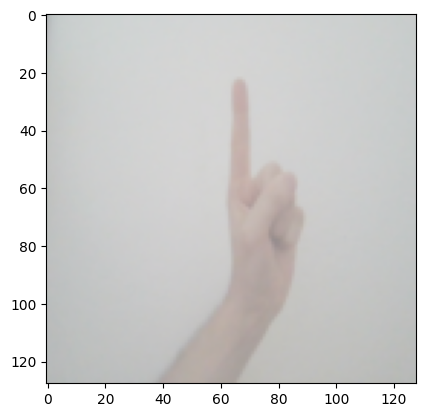

Label: nogesture
Image 2


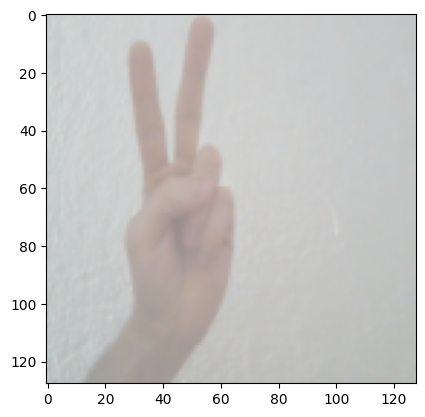

Label: peace
Image 3


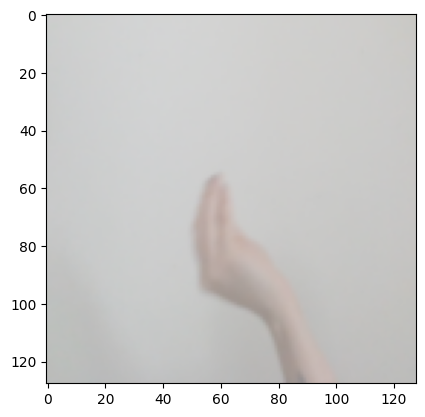

Label: checazzo
Image 4


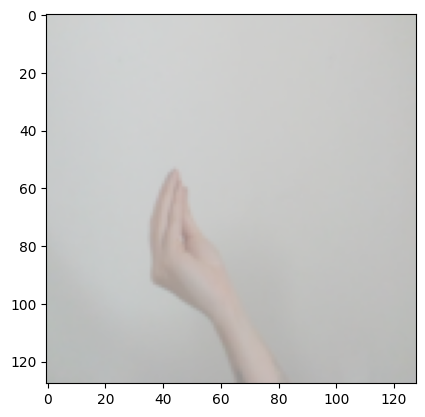

Label: checazzo
Image 5


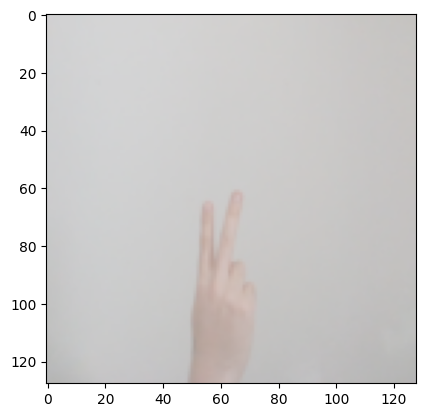

Label: peace
Image 6


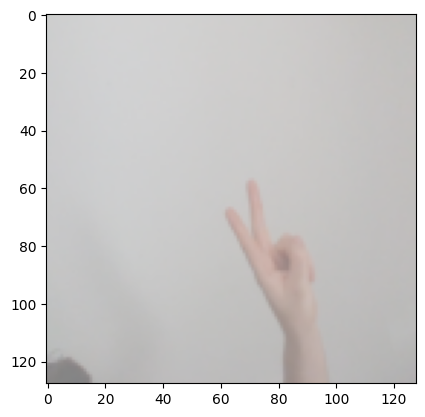

Label: peace
Image 7


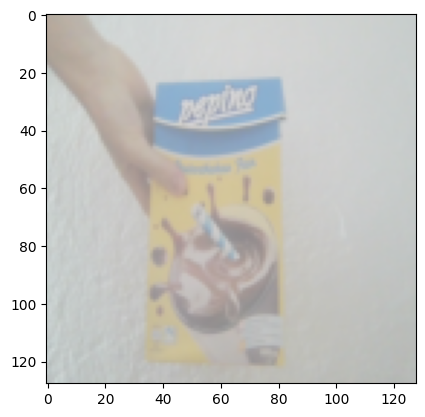

Label: nogesture
Image 8


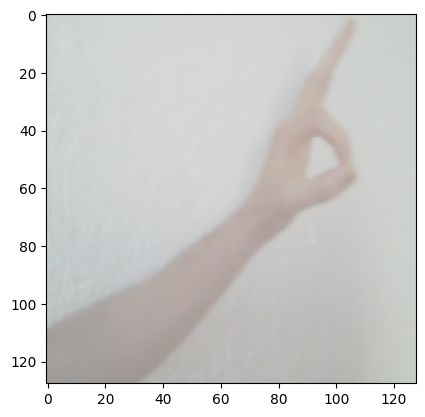

Label: nice
Image 9


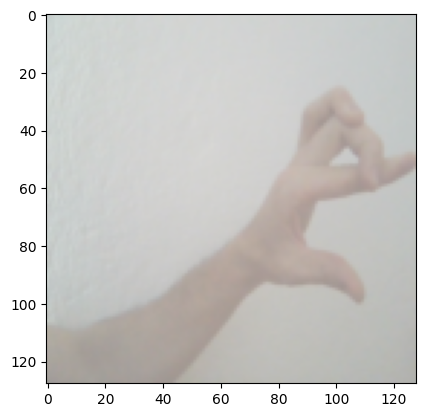

Label: nogesture
Image 10


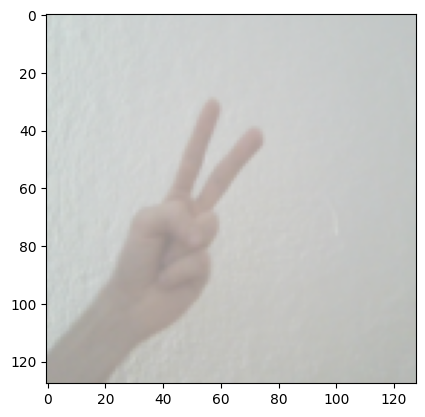

Label: peace
Image 11


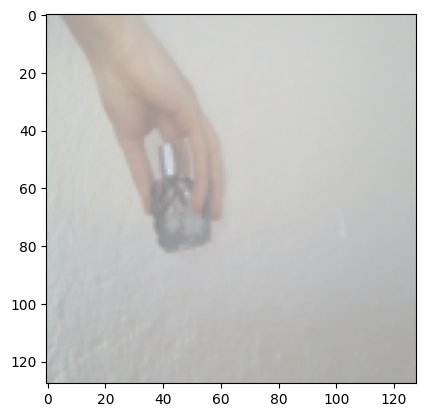

Label: nogesture
Image 12


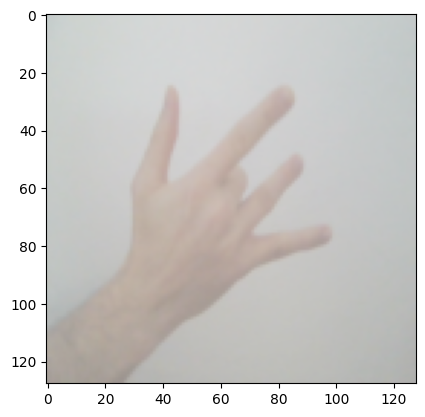

Label: nogesture
Image 13


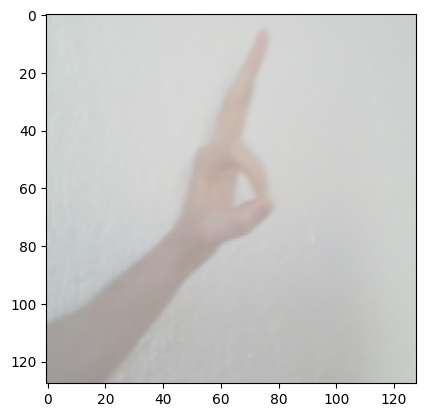

Label: nice
Image 14


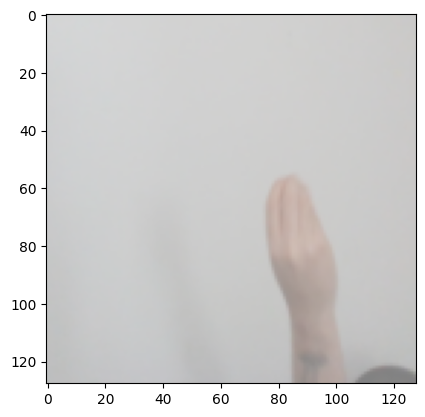

Label: checazzo
Image 15


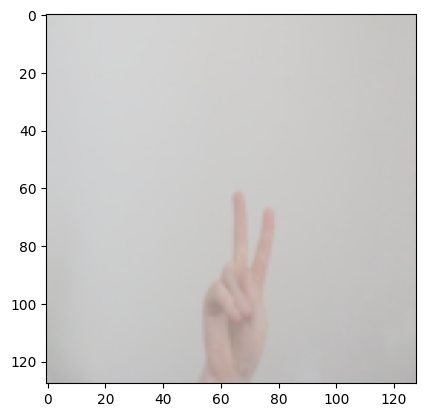

Label: peace
Image 16


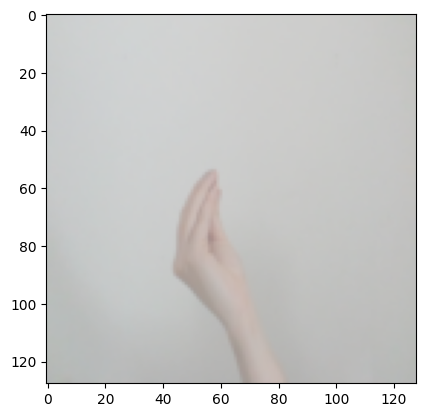

Label: checazzo
Image 17


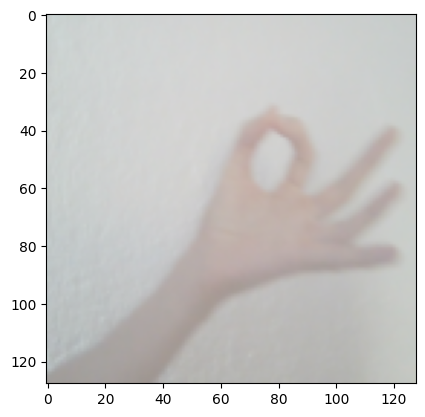

Label: nice
Image 18


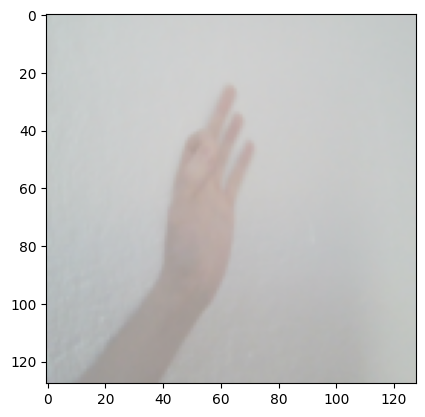

Label: nice
Image 19


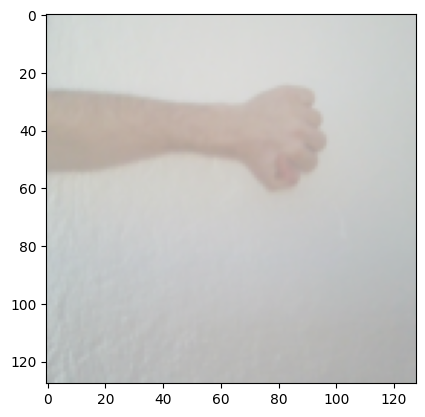

Label: nogesture
Image 20


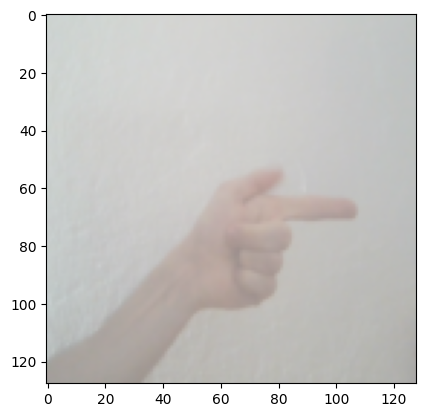

Label: nogesture
Image 21


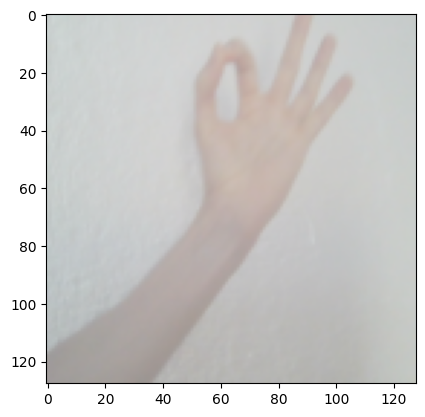

Label: nice
Image 22


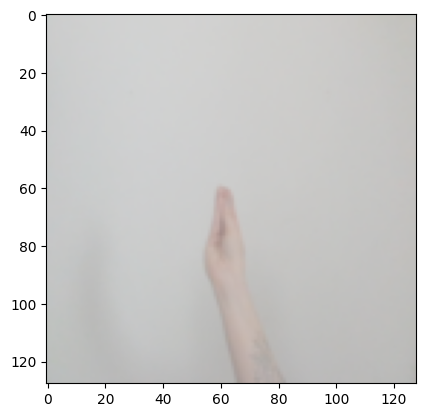

Label: checazzo
Image 23


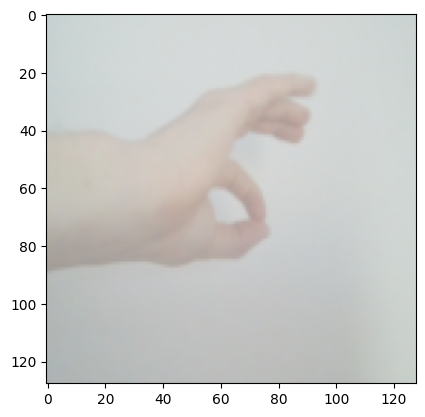

Label: nice
Image 24


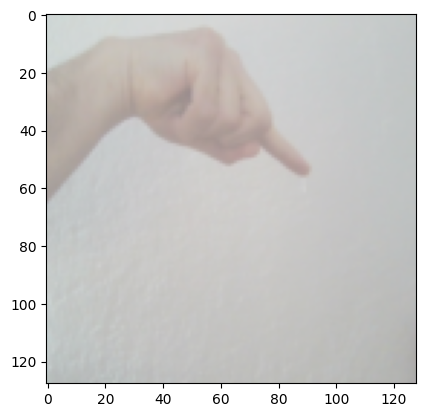

Label: nogesture
Image 25


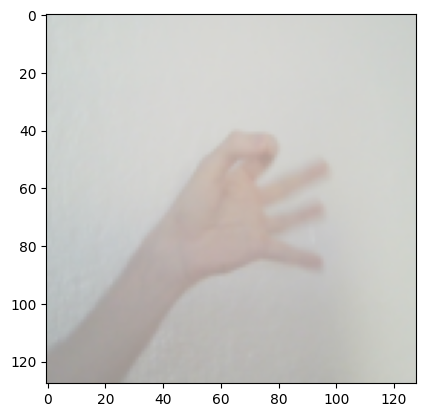

Label: nice
Image 26


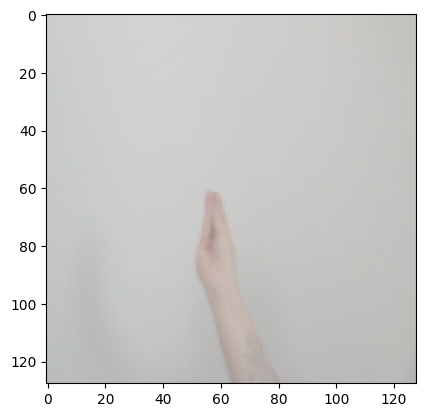

Label: checazzo
Image 27


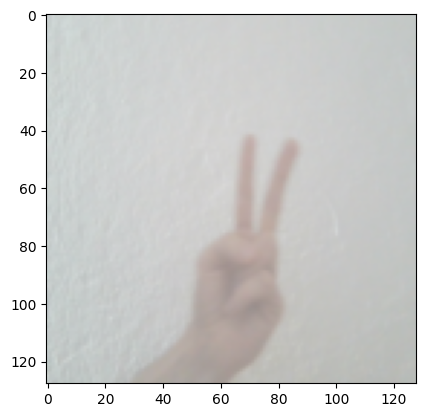

Label: peace
Image 28


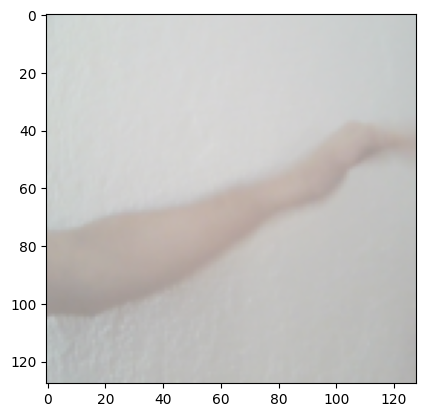

Label: nogesture
Image 29


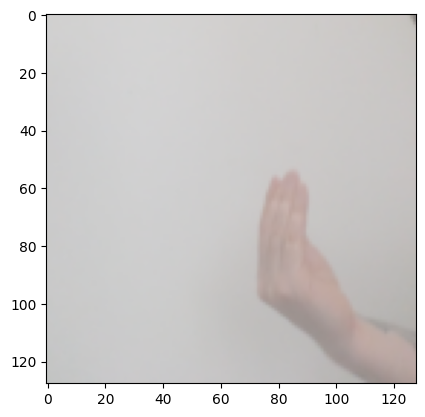

Label: checazzo
Image 30


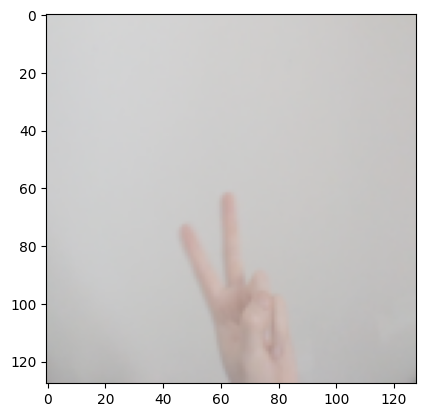

Label: peace
Image 31


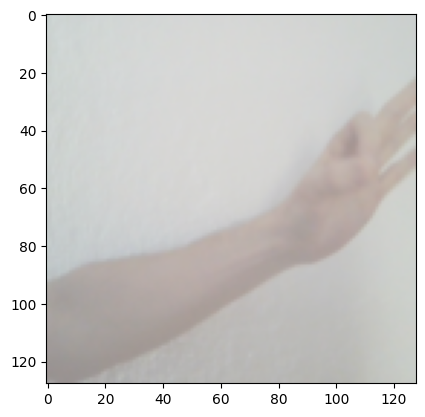

Label: nice
Image 32


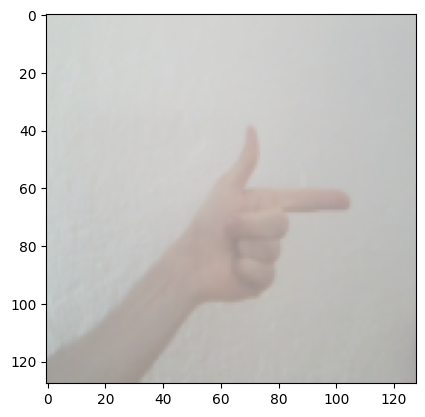

Label: nogesture


In [ ]:
# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()

    # Remove extra singleton dimensions (1, 1, 3, 32, 32) => (3, 32, 32)
    npimg = np.squeeze(npimg)  # Remove the extra singleton dimensions

    # If the image has 3 channels (RGB), we can directly display it
    if npimg.shape[0] == 3:
        npimg = np.transpose(npimg, (1, 2, 0))  # Transpose to (32, 32, 3) for RGB format

    plt.imshow(npimg)  # Show the image with RGB channels
    plt.show()
    

# Get some random training images
dataset_iter = iter(train_loader_original)
images, labels = next(dataset_iter)

"""# Loop through each image in the batch
for i, image in enumerate(images):
    print(f"Image {i + 1}")
    imshow(image)
    print(f"Label: {classes[labels[i].item()]}")"""

## CNN

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

##CNN Architecture

#Generally the CNN output size can be calculated as follows (for an image with same height and width dimensions):
#output_size = ((input_size - kernel_size + 2*padding) / stride) + 1

#Since we transform each image to grayscale we have 1 input channel.
# Also we use padding, because the most relevant informations lie in the center of the images.csv

#input size of each image: 128x128

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, padding=1) #output size = 124x124
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=1) #output size = 60*60
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) #output size = 30*30
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, padding=1) #output size = 14*14
        #self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        #self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        # Pooling layer for downsampling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout layers for regularization
        self.dropout = nn.Dropout(0.5)


        # Fully connected layers
        self.fc1 = nn.Linear(64*7*7, 1000)
        self.fc2 = nn.Linear(1000, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 4) #4 output classes 3 gestures and 1 for no gesture

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # output size = 62*62
        x = self.pool(F.relu(self.conv2(x))) # output size = 30*30
        x = self.pool(F.relu(self.conv3(x))) #output size = 15*15
        x = self.pool(F.relu(self.conv4(x))) # output size = 7*7

       # x = F.relu(self.conv5(x)) #output size = 8x8
       # x = self.pool(F.relu(self.conv6(x))) # output size = 4x4

        x = x.view(-1, 64*7*7)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.fc5(x) #no activation function because we use CrossEntropyLoss

        return x

In [9]:
#Hyperparameters
LEARNING_RATE = 0.001
EPOCHS = 50

# Check if the GPU is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(device)


model_original = Net()
optimizer_original = torch.optim.Adam(model_original.parameters(), lr=LEARNING_RATE)

model_100 = Net()
optimizer_100 = torch.optim.Adam(model_100.parameters(), lr=LEARNING_RATE)

model_200 = Net()
optimizer_200 = torch.optim.Adam(model_200.parameters(), lr=LEARNING_RATE)

model_300 = Net()
optimizer_300 = torch.optim.Adam(model_300.parameters(), lr=LEARNING_RATE)


criterion = nn.CrossEntropyLoss()

print(model_original)


cpu
Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=4, bias=True)
)


In [10]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [11]:
from torchsummary import summary

summary(model_original, (3, 128, 128)) # (channels, height, width of input image)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 126, 126]             608
         MaxPool2d-2            [-1, 8, 63, 63]               0
            Conv2d-3           [-1, 16, 61, 61]           3,216
         MaxPool2d-4           [-1, 16, 30, 30]               0
            Conv2d-5           [-1, 32, 30, 30]           4,640
         MaxPool2d-6           [-1, 32, 15, 15]               0
            Conv2d-7           [-1, 64, 14, 14]          32,832
         MaxPool2d-8             [-1, 64, 7, 7]               0
            Linear-9                 [-1, 1000]       3,137,000
          Dropout-10                 [-1, 1000]               0
           Linear-11                  [-1, 512]         512,512
          Dropout-12                  [-1, 512]               0
           Linear-13                  [-1, 256]         131,328
          Dropout-14                  [

In [12]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [13]:

def train(model, train_loader, optimizer, criterion, n_epochs=None):
    model.train()
    losses = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader,0):
        
        #get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.float()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            loss_value = loss.item()
            losses.append(loss_value)
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, loss: {running_loss / len(train_loader)}")

    print('Finished Training')
    return losses


Epoch 1, loss: 1.38747718334198
Epoch 2, loss: 1.387452745437622
Epoch 3, loss: 1.387767231464386
Epoch 4, loss: 1.3858326077461243
Epoch 5, loss: 1.387532889842987
Epoch 6, loss: 1.3867879509925842
Epoch 7, loss: 1.3868215203285217
Epoch 8, loss: 1.3872952818870545
Epoch 9, loss: 1.3863240599632263
Epoch 10, loss: 1.3854968070983886
Epoch 11, loss: 1.3829129695892335
Epoch 12, loss: 1.3693786144256592
Epoch 13, loss: 1.350607979297638
Epoch 14, loss: 1.2492801427841187
Epoch 15, loss: 1.1193328261375428
Epoch 16, loss: 1.0580598831176757
Epoch 17, loss: 1.0628782093524933
Epoch 18, loss: 1.0003403425216675
Epoch 19, loss: 0.9410713315010071
Epoch 20, loss: 0.9256269872188568
Epoch 21, loss: 0.8617846190929412
Epoch 22, loss: 0.7337996423244476
Epoch 23, loss: 0.7174669206142426
Epoch 24, loss: 0.6825417160987854
Epoch 25, loss: 0.6489082932472229
Epoch 26, loss: 0.5769816726446152
Epoch 27, loss: 0.46984869837760923
Epoch 28, loss: 0.5246748924255371
Epoch 29, loss: 0.5741859644651413

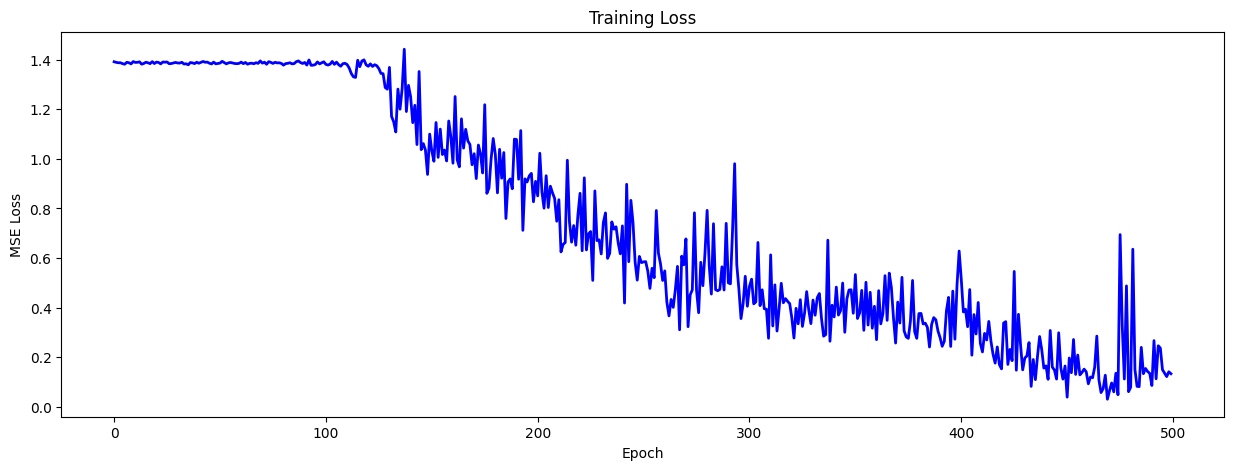

In [14]:
losses_original = train(model=model_original, train_loader=train_loader_original, optimizer=optimizer_original, criterion=criterion, n_epochs=EPOCHS)

plt.figure(figsize=(15, 5))
plt.plot(losses_original, lw=2,color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model
PATH = './model_original.pth'
torch.save(model_original.state_dict(), PATH)

Epoch 1, loss: 1.3885647237300873
Epoch 2, loss: 1.3854936718940736
Epoch 3, loss: 1.385086339712143
Epoch 4, loss: 1.388375425338745
Epoch 5, loss: 1.3852693736553192
Epoch 6, loss: 1.3864756941795349
Epoch 7, loss: 1.3849230885505677
Epoch 8, loss: 1.3856972217559815
Epoch 9, loss: 1.3872781276702881
Epoch 10, loss: 1.387085598707199
Epoch 11, loss: 1.3872183322906495
Epoch 12, loss: 1.386553055047989
Epoch 13, loss: 1.386198341846466
Epoch 14, loss: 1.3855549812316894
Epoch 15, loss: 1.3861737728118897
Epoch 16, loss: 1.3865593373775482
Epoch 17, loss: 1.386304247379303
Epoch 18, loss: 1.3865770041942596
Epoch 19, loss: 1.3872581779956819
Epoch 20, loss: 1.3872596085071565
Epoch 21, loss: 1.3866918861865998
Epoch 22, loss: 1.3855596721172332
Epoch 23, loss: 1.3861678123474122
Epoch 24, loss: 1.384928810596466
Epoch 25, loss: 1.3852836787700653
Epoch 26, loss: 1.3871348679065705
Epoch 27, loss: 1.3862925589084625
Epoch 28, loss: 1.3868098855018616
Epoch 29, loss: 1.3849212586879731
E

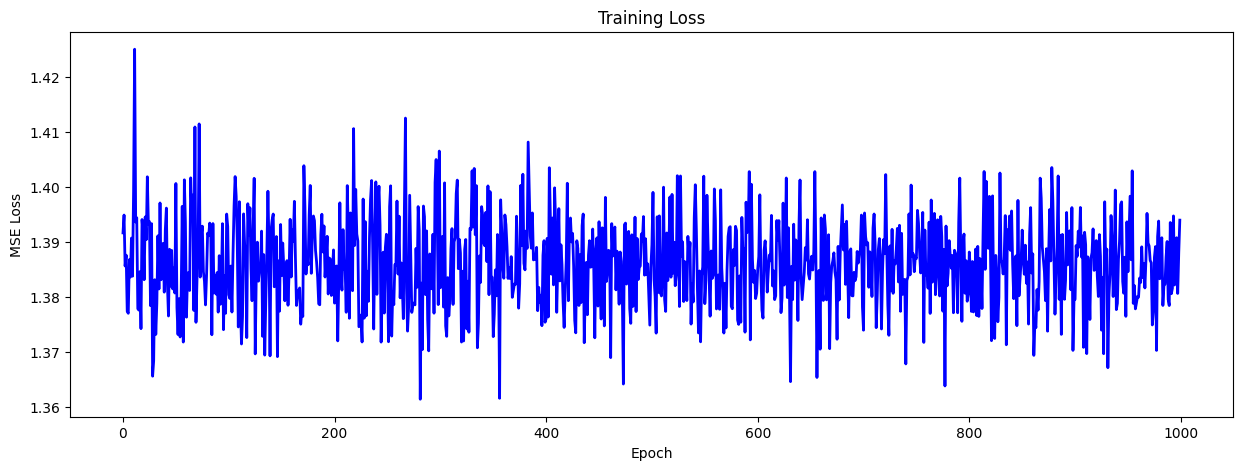

In [15]:
losses_100 = train(model=model_100, train_loader=train_loader_100, optimizer=optimizer_100, criterion=criterion, n_epochs=EPOCHS)

plt.figure(figsize=(15, 5))
plt.plot(losses_100, lw=2,color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model
PATH = './model_100.pth'
torch.save(model_100.state_dict(), PATH)

Epoch 1, loss: 1.388141918182373
Epoch 2, loss: 1.387261692682902
Epoch 3, loss: 1.3851661682128906
Epoch 4, loss: 1.3866596817970276
Epoch 5, loss: 1.3871309439341226
Epoch 6, loss: 1.382564111550649
Epoch 7, loss: 1.3657634536425272
Epoch 8, loss: 1.300766909122467
Epoch 9, loss: 1.1376753310362497
Epoch 10, loss: 1.064659317334493
Epoch 11, loss: 0.9356988906860352
Epoch 12, loss: 0.9411145408948263
Epoch 13, loss: 0.8313068211078644
Epoch 14, loss: 0.7043723702430725
Epoch 15, loss: 0.6137241045633952
Epoch 16, loss: 0.5999971320231755
Epoch 17, loss: 0.5087894678115845
Epoch 18, loss: 0.4513991862535477
Epoch 19, loss: 0.3875852917631467
Epoch 20, loss: 0.4101359804471334
Epoch 21, loss: 0.3050562140842279
Epoch 22, loss: 0.2286959039668242
Epoch 23, loss: 0.18794524632394313
Epoch 24, loss: 0.2001703719298045
Epoch 25, loss: 0.1849980724354585
Epoch 26, loss: 0.2046856348713239
Epoch 27, loss: 0.1816919520497322
Epoch 28, loss: 0.15511429601659377
Epoch 29, loss: 0.13410681150853

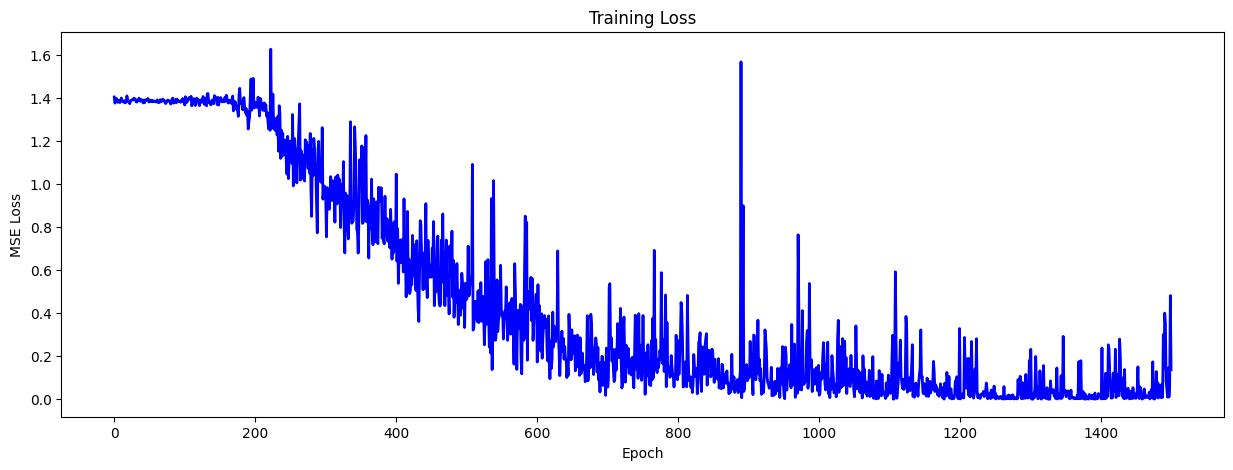

In [16]:
losses_200 = train(model=model_200, train_loader=train_loader_200, optimizer=optimizer_200, criterion=criterion, n_epochs=EPOCHS)

plt.figure(figsize=(15, 5))
plt.plot(losses_200, lw=2,color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model
PATH = './model_200.pth'
torch.save(model_200.state_dict(), PATH)

Epoch 1, loss: 1.388034576177597
Epoch 2, loss: 1.3845992475748061
Epoch 3, loss: 1.3693145245313645
Epoch 4, loss: 1.3189059406518937
Epoch 5, loss: 1.2789430499076844
Epoch 6, loss: 1.2195644170045852
Epoch 7, loss: 1.0731984570622444
Epoch 8, loss: 1.0173810377717019
Epoch 9, loss: 0.9972016587853432
Epoch 10, loss: 0.943278868496418
Epoch 11, loss: 0.9284340545535088
Epoch 12, loss: 0.836428590118885
Epoch 13, loss: 0.757767403125763
Epoch 14, loss: 0.6808727577328682
Epoch 15, loss: 0.59834353774786
Epoch 16, loss: 0.5812031529843807
Epoch 17, loss: 0.4929362051188946
Epoch 18, loss: 0.4610076565295458
Epoch 19, loss: 0.3904554594308138
Epoch 20, loss: 0.3025615932419896
Epoch 21, loss: 0.28478250075131656
Epoch 22, loss: 0.2620136125013232
Epoch 23, loss: 0.2401901876553893
Epoch 24, loss: 0.22577524594962597
Epoch 25, loss: 0.22666946165263652
Epoch 26, loss: 0.18076306949369608
Epoch 27, loss: 0.1703400758560747
Epoch 28, loss: 0.13765596402809024
Epoch 29, loss: 0.142906531179

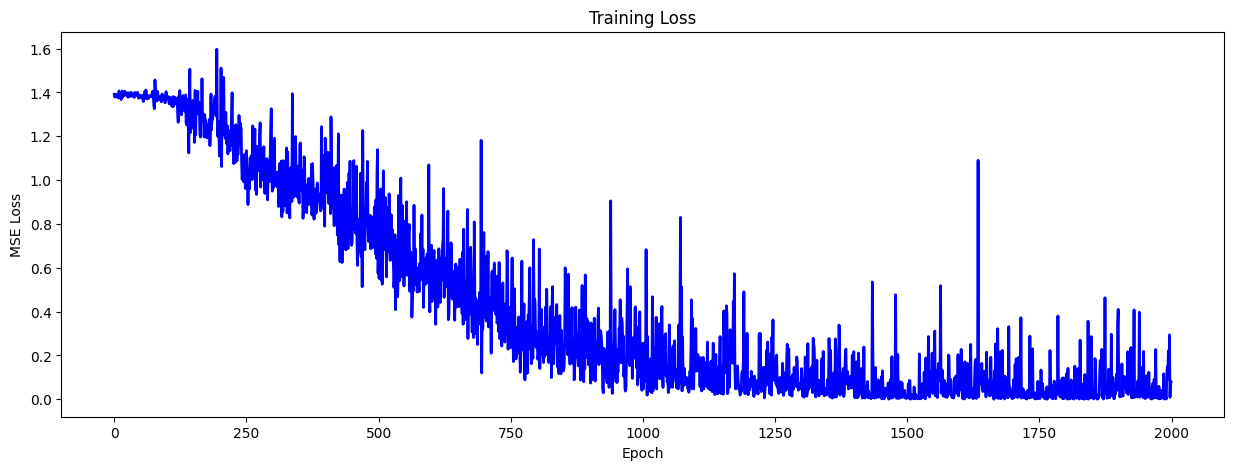

In [17]:
losses_300 = train(model=model_300, train_loader=train_loader_300, optimizer=optimizer_300, criterion=criterion, n_epochs=EPOCHS)

plt.figure(figsize=(15, 5))
plt.plot(losses_300, lw=2,color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model
PATH = './model_300.pth'
torch.save(model_300.state_dict(), PATH)

C:\Users\gabri\AppData\Local\Temp\ipykernel_23012\3775393825.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_original.load_state_dict(torch.load('model_original.pt

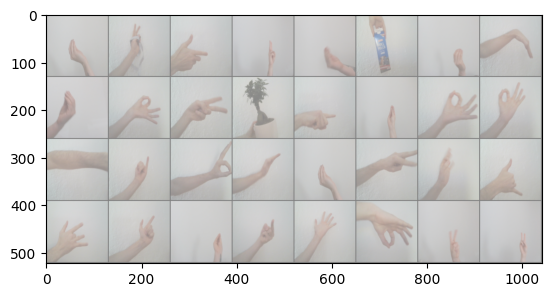

In [18]:
model_original.load_state_dict(torch.load('model_original.pth'))

# Check the testset
dataiter = iter(test_loader_original)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images.cpu()))


# Evaluation

In [19]:
def test_accuracy(model, test_loader, device='cpu'):
    """
    Calculate and return the accuracy of the model on the test set.

    Parameters:
    - model: The trained PyTorch model
    - test_loader: DataLoader for the test dataset
    - device: The device ('cpu' or 'cuda') on which the model and data reside

    Returns:
    - accuracy: Overall accuracy of the model on the test set (in percentage)
    """
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient computation
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            images = images.float()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Compute overall accuracy
    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy:.2f} %')
    return accuracy


In [20]:
# Calculate the overall accuracy
print("Model original")
overall_accuracy_original = test_accuracy(model_original, test_loader_original, device=device)

print("Model 100")
overall_accuracy_100 = test_accuracy(model_100, test_loader_100, device=device)

print("Model 200")
overall_accuracy_200 = test_accuracy(model_200, test_loader_200, device=device)

print("Model 300")
overall_accuracy_300 = test_accuracy(model_300, test_loader_300, device=device)



Model original
Accuracy of the network on the test images: 92.50 %
Model 100
Accuracy of the network on the test images: 20.00 %
Model 200
Accuracy of the network on the test images: 90.83 %
Model 300
Accuracy of the network on the test images: 90.00 %


In [21]:
def accuracy(model, test_loader, classes, device='cpu'):
    """
    Calculate and print the accuracy for each class.

    Parameters:
    - model: The trained PyTorch model
    - test_loader: DataLoader for the test dataset
    - classes: List of class names
    - device: The device ('cpu' or 'cuda') on which the model and data reside

    Returns:
    - class_accuracies: A dictionary with class names as keys and accuracy percentages as values
    """
    # Switch the model to evaluation mode
    model.eval()

    # Initialize variables for correct and total counts per class
    class_correct = list(0. for _ in range(len(classes)))
    class_total = list(0. for _ in range(len(classes)))

    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            images = images.float()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i].item()
                class_correct[label] += c[i].item()
                class_total[label] += 1

    # Compute and print accuracy for each class
    class_accuracies = {}
    for i in range(len(classes)):
        if class_total[i] > 0:  # Check to avoid division by zero
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'Accuracy of {classes[i]} : {accuracy:.2f} %')
            class_accuracies[classes[i]] = accuracy
        else:
            print(f'Accuracy of {classes[i]} : No samples available')
            class_accuracies[classes[i]] = None

    return class_accuracies


In [22]:
# Call the accuracy function
print("Model original")
class_accuracies = accuracy(model_original, test_loader_original, classes, device=device)

print("Model 100")
class_accuracies_100 = accuracy(model_100, test_loader_100, classes, device=device)

print("Model 200")
class_accuracies_200 = accuracy(model_200, test_loader_200, classes, device=device)

print("Model 300")
class_accuracies_300 = accuracy(model_300, test_loader_300, classes, device=device)


Model original
Accuracy of checazzo : 100.00 %
Accuracy of peace : 78.95 %
Accuracy of nice : 100.00 %
Accuracy of nogesture : 89.47 %
Model 100
Accuracy of checazzo : 0.00 %
Accuracy of peace : 100.00 %
Accuracy of nice : 0.00 %
Accuracy of nogesture : 0.00 %
Model 200
Accuracy of checazzo : 92.11 %
Accuracy of peace : 86.54 %
Accuracy of nice : 95.08 %
Accuracy of nogesture : 88.24 %
Model 300
Accuracy of checazzo : 95.83 %
Accuracy of peace : 78.75 %
Accuracy of nice : 90.32 %
Accuracy of nogesture : 93.90 %


In [23]:
from sklearn.metrics import f1_score

def calculate_f1_score(y_true, y_pred, average='weighted'):
    """
    Calculate the F1 score for a classification problem.

    Parameters:
    - y_true: List or array of true class labels
    - y_pred: List or array of predicted class labels
    - average: The averaging method ('micro', 'macro', or 'weighted')

    Returns:
    - f1: F1 score (float)
    """
    f1 = f1_score(y_true, y_pred, average=average)
    print(f"F1 Score ({average}): {f1:.2f}")
    return f1


In [24]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate and visualize results
def evaluate_model(model, test_loader, label_map, device='cpu',average='weighted'):
    """
    Evaluate the model on a test set and visualize the results.

    Parameters:
    - model: The trained PyTorch model
    - test_loader: DataLoader for the test dataset
    - label_map: Dictionary mapping class indices to class names
    - device: The device ('cpu' or 'cuda') on which the model and data reside

    Returns:
    - accuracy: Overall accuracy of the model on the test set (in percentage)
    - conf_matrix: Confusion matrix of the test set predictions
    """
    model.eval()  # Set the model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            images = images.float()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    # Compute accuracy
    correct = sum(p == l for p, l in zip(all_preds, all_labels))
    total = len(all_labels)
    accuracy = 100 * correct / total

    #Compute F1 score
    f1 = calculate_f1_score(all_labels, all_preds, average=average)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Print accuracy
    print(f"Accuracy of the network on the test set: {accuracy:.2f}%")

    # Visualize confusion matrix
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", 
                xticklabels=label_map.values(), 
                yticklabels=label_map.values())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, conf_matrix, f1


Model original
F1 Score (weighted): 0.92
Accuracy of the network on the test set: 92.50%


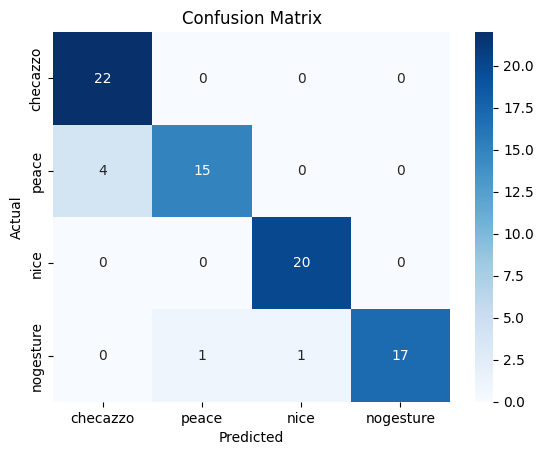

Model 100
F1 Score (weighted): 0.07
Accuracy of the network on the test set: 20.00%


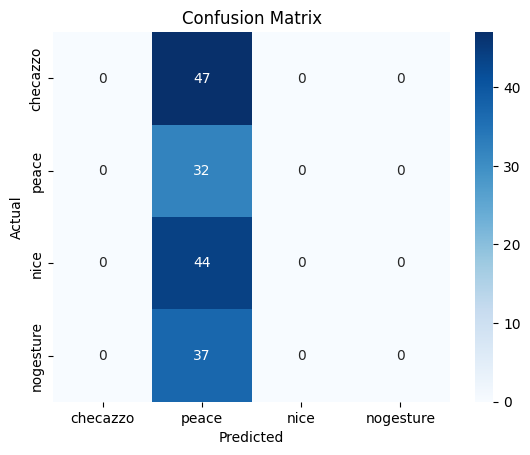

Model 200
F1 Score (weighted): 0.91
Accuracy of the network on the test set: 90.83%


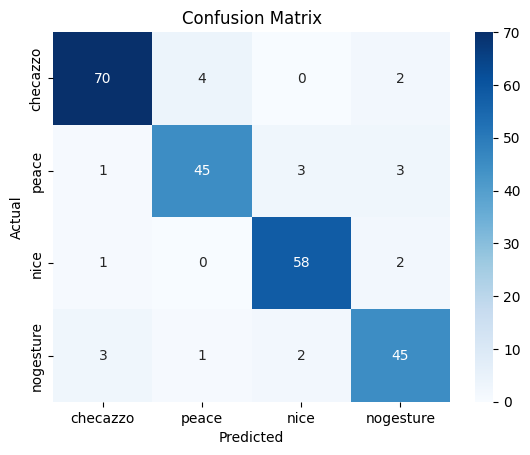

Model 300
F1 Score (weighted): 0.90
Accuracy of the network on the test set: 90.00%


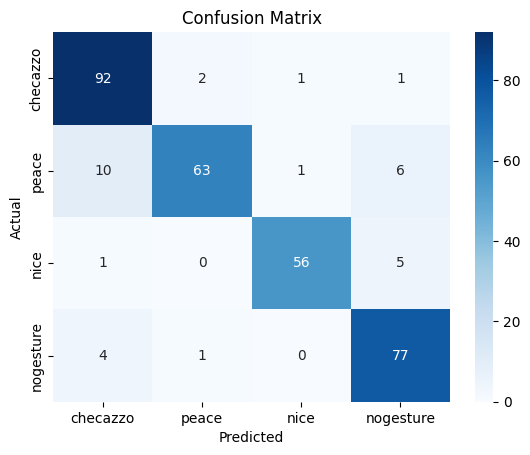

In [25]:
# Define the label map
label_map = {i: class_name for i, class_name in enumerate(classes)}

# Evaluate the model
print("Model original")
overall_accuracy, confusion_mat, f1 = evaluate_model(model_original, test_loader_original, label_map, device=device,average='weighted')

print("Model 100")
overall_accuracy_100, confusion_mat_100, f1_100 = evaluate_model(model_100, test_loader_100, label_map, device=device,average='weighted')

print("Model 200")
overall_accuracy_200, confusion_mat_200, f1_200 = evaluate_model(model_200, test_loader_200, label_map, device=device,average='weighted')

print("Model 300")
overall_accuracy_300, confusion_mat_300, f1_300 = evaluate_model(model_300, test_loader_300, label_map, device=device,average='weighted')
